<a href="https://colab.research.google.com/github/MaxHenk/2022_ML_EES/blob/main/ML_PROJECT_MH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projet pour le cours de Machine Learning for Earth & Environmental Sciences.

I will do a classification once for the arrival times and once for the departure times, to see if the environmental variables are better at explaining delays in departures or arrivals.

In [ ]:
%pip install geopandas
%pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 
     |████████████████████████████████| 16.6 MB 98 kB/s 
     |████████████████████████████████| 7.8 MB 52.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 5.0 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp38-cp38-linux_x86_64.whl size=236291 sha256=6b79e49721ff0424a2b174d30ac457e53231344dc00fde5905754314dd91da91
  Stored in directory: /root/.cache/pip/wheels/25/d4/61/dbd8edd1a0d656be7b4267c85db3b61951eb60016a0154a122
Successfully built pickle5


In [50]:
#Import Libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle5 as pickle
import pooch
import matplotlib.pyplot as plt     

rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

In [51]:
#Data Loading
csv_path = 'https://unils-my.sharepoint.com/:x:/g/personal/max_henking_unil_ch/EaMaqY8dMIVPgmgg9nCTRc0BTFBUn0pTYsfyAeu9OUIbOA?download=1'
hash='c93694580afdc2c624d66f6a94d60ca5deee03efbd1008e50ae4f9e420e208c3'
csv_file = pooch.retrieve(csv_path, known_hash=hash)

d1 = pd.read_csv(csv_file, index_col=0)
df = gpd.GeoDataFrame(d1, geometry=gpd.points_from_xy(d1.Geoposit_1,d1.Geopositio))

In [52]:
#Renaming for clarity
df.rename(columns = {'Ankunftsze':'exparr_date'},inplace=True)
df.rename(columns = {'An Prognos':'actarr_date'},inplace=True)
df.rename(columns = {'Ankunftsve':'arrlate3min'},inplace=True)
df.rename(columns = {'Abfahrtsze': 'expdep_date'},inplace=True)
df.rename(columns = {'departure': 'actdep_date'},inplace=True)
df.rename(columns = {'departur_1': 'deplate3min'},inplace=True)
df.rename(columns = {'Verkehrsmi': 'train_type'},inplace=True)
df.rename(columns = {'Fällt aus': 'cancelled'},inplace = True)

#Changing type
fmt = '%Y/%m/%d %H:%M:%S'
df['actarr_date'] = pd.to_datetime(df['actarr_date'],
                                     format=fmt,
                                     errors='coerce')
df['exparr_date'] = pd.to_datetime(df['exparr_date'],
                                     format=fmt,
                                     errors='coerce')
df['actdep_date'] = pd.to_datetime(df['actdep_date'],
                                     format=fmt,
                                     errors='coerce')
df['expdep_date'] = pd.to_datetime(df['expdep_date'],
                                     format=fmt,
                                     errors='coerce')
#New columns with exact delays (departure and arrival)
df['latedep'] = (df['expdep_date'].dt.minute + df['expdep_date'].dt.second/60) - (df['actdep_date'].dt.minute + df['actdep_date'].dt.second/60)
df['latearr'] = (df['exparr_date'].dt.minute + df['exparr_date'].dt.second/60) - (df['actarr_date'].dt.minute + df['actarr_date'].dt.second/60)

#Cleaning of input columns
df.arrlate3min = df.arrlate3min.replace({True: 1, False: 0})
df.deplate3min = df.deplate3min.replace({True: 1, False: 0})
df.cancelled = df.cancelled.replace({True: 1, False: 0})
df.tre200h0 = df.tre200h0.replace('-', None)
df.sre000h0 = df.sre000h0.replace('-', None)
df.rre150h0 = df.rre150h0.replace('-', None)
df_wo_na = df.dropna(axis= 0, how='any')

In [53]:
#Encoding categorical variables so they can be used as an input
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
#Instantiate the numerical pipeline
num_pipeline = Pipeline([ # We'll instantiate the pipeline class
     ("scaler", StandardScaler() ) ]) # as well as the scaler

#Instantiate the categorical Pipeline
cat_pipeline = Pipeline( [ # Once again we instantiate the pipeline class
    ("cat_encoder", OneHotEncoder(sparse=False)) ] )
#Choose which numerical/categorical variables to input
num_attribs = ['tre200h0','sre000h0','rre150h0','cancelled']
cat_attribs = ["Abkuerzung", "train_type"]
preprocess_pipeline = ColumnTransformer( [("num", num_pipeline, num_attribs),
                                          ("cat", cat_pipeline, cat_attribs) ] )

#Do the encoding
X = preprocess_pipeline.fit_transform( # Fit your pipeline using the training input data and transform the training input data in one step!
              df[num_attribs + cat_attribs] ) # load the categorical and numerical attributes from the training dataframe

y = df["deplate3min"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=rnd_seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=rnd_seed)


In [57]:
X_test.shape

(11469, 618)

In [ ]:
# Import the LogisticRegression class from sklearn
from sklearn.linear_model import LogisticRegression

# And instantiate the model
log_reg = LogisticRegression()

# Fit the logistic regression to the training set
log_reg.fit(X_train, y_train)

#Make a prediction using the validation/test set
prediction_train = log_reg.predict(X_train)
prediction_valid = log_reg.predict(X_valid)
prediction_test = log_reg.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


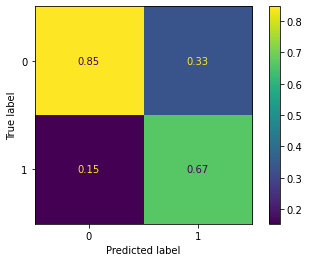

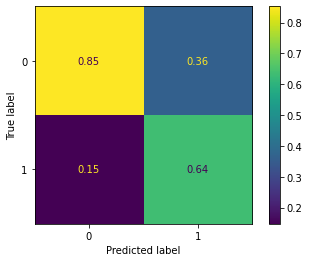

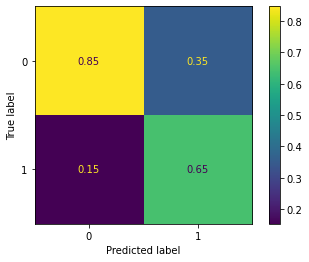

In [58]:
#Do a accuracy score to get the amount of
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

log_reg_acc_train = accuracy_score(y_train, prediction_train)
log_reg_acc_valid = accuracy_score(y_valid, prediction_valid)
log_reg_acc_test = accuracy_score(y_test, prediction_test)

cm = confusion_matrix(y_train, prediction_train, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix= cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()
     
cm = confusion_matrix(y_valid, prediction_valid, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix= cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()

cm = confusion_matrix(y_test, prediction_test, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix= cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()

In [60]:
print('The accuracy is ',log_reg_acc_train)
print('The accuracy is ',log_reg_acc_valid)
print('The accuracy is ',log_reg_acc_test)

The accuracy is  0.8406267029972752
The accuracy is  0.8452316076294278
The accuracy is  0.8394803383032522


In [62]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train,y_train)

svc_prediction_train = svm_clf.predict(X_train)
svc_prediction_valid = svm_clf.predict(X_valid)
svc_prediction_test = svm_clf.predict(X_test)

In [67]:
y_train

1016908    0
42722      0
501700     1
301494     1
1009587    0
          ..
502837     0
344257     1
503801     0
843205     1
299483     0
Name: deplate3min, Length: 36700, dtype: int64

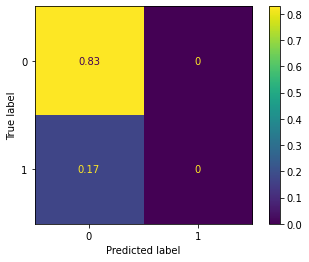

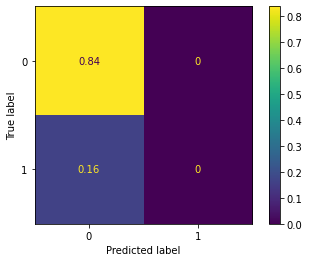

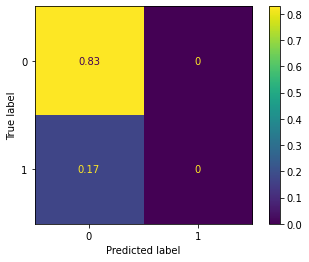

In [68]:
svc_acc_train = accuracy_score(y_train, svc_prediction_train)
svc_acc_valid = accuracy_score(y_valid, svc_prediction_valid)
svc_acc_test = accuracy_score(y_test, svc_prediction_test)

cm = confusion_matrix(y_train, svc_prediction_train, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix= cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()
     
cm = confusion_matrix(y_valid, svc_prediction_valid, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix= cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()

cm = confusion_matrix(y_test, svc_prediction_test, normalize='pred') # Get a confusion matrix 'cm', use 'pred' for the normalize option
disp = ConfusionMatrixDisplay(confusion_matrix= cm) # Use ConfusionMatrixDisplay to visualize 'cm'
disp.plot()

In [64]:
print('The accuracy is ',svc_acc_train)
print('The accuracy is ',svc_acc_valid)
print('The accuracy is ',svc_acc_test)

The accuracy is  0.8283651226158039
The accuracy is  0.8360762942779292
The accuracy is  0.8284070102014125


In [ ]:
#Problem happened with saving, had to redo so no time to comment or understant why confusion matrix is different than in paper